In [64]:
from typing import TypedDict, Tuple

import numpy as np
from temgymbasic import components as comp
from temgymbasic.components import DoubleDeflector, Lens, Sample
from temgymbasic.model import STEMModel
import matplotlib.pyplot as plt
import matplotlib as mpl



In [65]:
def show_matplotlib(model, rays, figsize = (6, 12), name='model.svg'):
    '''Code to show a matplotlib model

    Parameters
    ----------
    model : class
        Microscope Model
    figsize : tuple
        Size of figure, determines the aspect ratio of the figure also
    name : str, optional
        Name of file, by default 'model.svg'
    component_lw : int, optional
        Linewidth of component outline, by default 4
    edge_lw : int, optional
        Linewidth of highlight to edges, by default 1
    label_fontsize : int, optional
        Fontsize of labels, by default 20

    Returns
    -------
    fig : class
        Matplotlib figure object
    ax : class
        Matplotlib axis object of the figure
    '''


    # Set colors of rays
    ray_color = 'dimgray'
    fill_color = 'aquamarine'
    fill_color_pair = ['khaki', 'deepskyblue']
    fill_alpha = 1
    ray_alpha = 1
    component_lw = 4
    edge_lw = 1
    ray_lw = 0.01
    label_fontsize=20

    aspect = figsize[1]/figsize[0]
    # Collect their x, y & z coordinates
    x = np.stack(tuple(r.x for r in rays), axis=0)
    dx = np.stack(tuple(r.dx for r in rays), axis=0)
    y = np.stack(tuple(r.y for r in rays), axis=0)
    dy = np.stack(tuple(r.dy for r in rays), axis=0)
    z = np.asarray(tuple(r.z for r in rays))

    # Create a figure
    fig, ax = plt.subplots(figsize=figsize)

    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(color='lightgrey', linestyle='--', linewidth=0.5)
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.set_yticks([])
    ax.set_yticklabels([])


    detector_size_x=model.detector.pixel_size * model.detector.shape[1]
    detector_size_y=model.detector.pixel_size * model.detector.shape[0]

    ax.get_xaxis().set_ticks(
        [-detector_size_x/2, 0, detector_size_x/2])
    ax.set_xlim([-detector_size_x, detector_size_x])
    ax.set_ylim([model.components[-1].z, model.components[0].z])
    ax.text(0, model.components[0].z, model.components[0].name, fontsize=label_fontsize, zorder=1000)

    ax.plot(x, z,
        color=ray_color, linewidth=ray_lw, alpha=ray_alpha, zorder=1)

    min_x_idx=np.argmin(x[0, :])
    max_x_idx=np.argmax(x[0, :])
    
    ax.fill_betweenx(z, x[:, min_x_idx], x[:, max_x_idx],
                color=fill_color, edgecolor=fill_color, alpha=fill_alpha, zorder=0, lw=None)
    
    ax.plot(x[:, min_x_idx], z,
        color=ray_color, linewidth=edge_lw, alpha=ray_alpha, zorder=1)
    
    ax.plot(x[:, max_x_idx], z,
        color=ray_color, linewidth=edge_lw, alpha=ray_alpha, zorder=1)
    
    # Optional: Mark the component positions
    extent = 1.0 * np.abs(x).max()
    for component in model.components:
        if isinstance(component, DoubleDeflector):
            # ax.hlines(
            #     component.first.z, -extent, extent, linestyle='--'
            # )
            # ax.text(-extent, component.first.z, repr(component.first), va='bottom')
            # ax.hlines(
            #     component.second.z, -extent, extent, linestyle='--'
            # )
            # ax.text(-extent, component.second.z, repr(component.second), va='bottom')
            radius = -detector_size_x/2
            ax.text(-extent, component.first.z, component.name, fontsize=label_fontsize, 
                    va='bottom', zorder=1000)
            ax.plot([-radius, 0], [component.first.z, component.first.z],
                    color='lightcoral', alpha=1, linewidth=component_lw, zorder=999)
            ax.plot([0, radius], [component.first.z, component.first.z],
                    color='lightblue', alpha=1, linewidth=component_lw, zorder=999)
            ax.plot([-radius, radius], [component.first.z, component.first.z],
                    color='k', alpha=0.8, linewidth=component_lw+2, zorder=998)
            ax.text(-extent, component.second.z, component.first.name, fontsize=label_fontsize, 
                    va='bottom', zorder=1000)
            ax.plot([-radius, 0], [component.second.z, component.second.z],
                    color='lightcoral', alpha=1, linewidth=component_lw, zorder=999)
            ax.plot([0, radius], [component.second.z, component.second.z],
                    color='lightblue', alpha=1, linewidth=component_lw, zorder=999)
            ax.plot([-radius, radius], [component.second.z, component.second.z],
                    color='k', alpha=0.8, linewidth=component_lw+2, zorder=998)
        elif isinstance(component, Lens):
            radius = -detector_size_x
            ax.text(extent, component.z, component.name, fontsize=label_fontsize, 
                    va='bottom', zorder=1000)
            ax.add_patch(mpl.patches.Arc((0, component.z), radius, height=0.03/aspect,
                                        theta1=0, theta2=180, linewidth=1, fill=False, zorder=-1, edgecolor='k'))
            ax.add_patch(mpl.patches.Arc((0, component.z), radius, height=0.03/aspect,
                                        theta1=180, theta2=0, linewidth=1, fill=False, zorder=999, edgecolor='k'))
        elif isinstance(component, Sample):
            ax.text(label_x, component.z-0.01,
                component.name, fontsize=label_fontsize, zorder=1000)
            w = component.width
            ax.plot([component.x-w/2, component.x+w/2], [z[idx], z[idx]],
                color='dimgrey', alpha=0.8, linewidth=3)

        idx += 1
        else:
            ax.hlines(component.z, -extent, extent, label=component.name)
            ax.text(-extent, component.z, component.name, va='bottom')

    plt.savefig('model.svg')
    '''
    ax.hlines(
        model.objective.ffp, -extent, extent, linestyle=':'
    )

    ax.axvline(color='black', linestyle=":", alpha=0.3)
    _, scan_pos_x = model.sample.scan_position(yx)
    ax.plot([scan_pos_x], [model.sample.z], 'ko')

    ax.set_xlabel('x position')
    ax.set_ylabel('z position')
    ax.invert_yaxis()
    ax.set_title(f'Ray paths for {num_rays} rays at position {yx}')

    if highlight_edges == True:
        ax.plot(x[idx-1:idx+1, edge_rays_idcs], z[idx-1:idx+1],
                color='k', linewidth=edge_lw, alpha=1, zorder=2)
    if fill_between == True:
        pair_idx = 0
        for first, second in zip(edge_rays_idcs[::2], edge_rays_idcs[1::2]):
            if len(edge_rays_idcs) == 4:
                ax.fill_betweenx(z[idx-1:idx+1], x[idx-1:idx+1, first], x[idx-1:idx+1, second],
                                    color=fill_color_pair[pair_idx], edgecolor=fill_color_pair[pair_idx], alpha=fill_alpha, zorder=0, lw=None)
                pair_idx += 1
            else:
                ax.fill_betweenx(z[idx-1:idx+1], x[idx-1:idx+1, first], x[idx-1:idx+1, second],
                                    color=fill_color, edgecolor=fill_color, alpha=fill_alpha, zorder=0, lw=None)
    if plot_rays == True:
        ax.plot(x[idx-1:idx+1, allowed_rays], z[idx-1:idx+1],
                color=ray_color, linewidth=ray_lw, alpha=ray_alpha, zorder=1)

    elif component.type == 'Double Deflector':
        r = component.radius
        ax.text(label_x, component.z_up-0.01, 'Upper '
                + component.name, fontsize=label_fontsize, zorder=1000)
        ax.plot([-r, 0], [z[idx], z[idx]],
                color='lightcoral', alpha=1, linewidth=component_lw, zorder=999)
        ax.plot([0, r], [z[idx], z[idx]],
                color='lightblue', alpha=1, linewidth=component_lw, zorder=999)
        ax.plot([-r, r], [z[idx], z[idx]],
                color='k', alpha=0.8, linewidth=component_lw+2, zorder=998)
        idx += 1

        if allowed_rays != []:
            if highlight_edges == True:
                ax.plot(x[idx-1:idx+1, edge_rays_idcs], z[idx-1:idx+1],
                        color='k', linewidth=edge_lw, alpha=1, zorder=2)
            if fill_between == True:
                pair_idx = 0
                for first, second in zip(edge_rays_idcs[::2], edge_rays_idcs[1::2]):
                    if len(edge_rays_idcs) == 4:
                        ax.fill_betweenx(z[idx-1:idx+1], x[idx-1:idx+1, first], x[idx-1:idx+1,
                                            second], color=fill_color_pair[pair_idx], alpha=fill_alpha, zorder=1)
                        pair_idx += 1
                    else:
                        ax.fill_betweenx(z[idx-1:idx+1], x[idx-1:idx+1, first], x[idx
                                            - 1:idx+1, second], color=fill_color, alpha=fill_alpha, zorder=0)
            if plot_rays == True:
                ax.plot(x[idx-1:idx+1, allowed_rays], z[idx-1:idx+1],
                        color=ray_color, linewidth=ray_lw, alpha=ray_alpha, zorder=1)

        ax.text(label_x, component.z_low-0.01,
                'Lower ' + component.name, fontsize=label_fontsize, zorder=1000)
        ax.plot([-r, 0], [z[idx], z[idx]],
                color='lightcoral', alpha=1, linewidth=component_lw, zorder=999)
        ax.plot([0, r], [z[idx], z[idx]],
                color='lightblue', alpha=1, linewidth=component_lw, zorder=999)
        ax.plot([-r, r], [z[idx], z[idx]],
                color='k', alpha=0.8, linewidth=component_lw+2, zorder=998)
        idx += 1

    elif component.type == 'Lens':
        ax.text(label_x, component.z-0.01,
                component.name, fontsize=label_fontsize, zorder=1000)
        ax.add_patch(mpl.patches.Arc((0, component.z), component.radius*2, height=0.05,
                                        theta1=0, theta2=180, linewidth=1, fill=False, zorder=-1, edgecolor='k'))
        ax.add_patch(mpl.patches.Arc((0, component.z), component.radius*2, height=0.05,
                                        theta1=180, theta2=0, linewidth=1, fill=False, zorder=999, edgecolor='k'))

        idx += 1

    elif component.type == 'Deflector':
        r = component.radius
        ax.text(label_x, component.z-0.01,
                component.name, fontsize=label_fontsize, zorder=1000)
        ax.plot([-r, 0], [z[idx], z[idx]],
                color='lightcoral', alpha=1, linewidth=component_lw, zorder=999)
        ax.plot([0, r], [z[idx], z[idx]],
                color='lightblue', alpha=1, linewidth=component_lw, zorder=999)
        ax.plot([-r, r], [z[idx], z[idx]],
                color='k', alpha=0.8, linewidth=component_lw+2, zorder=998)

        idx += 1

    elif component.type == 'Sample':
        ax.text(label_x, component.z-0.01,
                component.name, fontsize=label_fontsize, zorder=1000)
        w = component.width
        ax.plot([component.x-w/2, component.x+w/2], [z[idx], z[idx]],
                color='dimgrey', alpha=0.8, linewidth=3)

        idx += 1

    allowed_rays = list(set(allowed_rays).difference(
        set(component.blocked_ray_idcs)))
    allowed_rays.sort()

    if len(allowed_rays) > 0:
        edge_rays_idcs = [allowed_rays[0], allowed_rays[-1]]
        new_edges = np.where(np.diff(allowed_rays) != 1)[0].tolist()

        for new_edge in new_edges:
            edge_rays_idcs.extend(
                [allowed_rays[new_edge], allowed_rays[new_edge+1]])

        edge_rays_idcs.sort()

    else:
        break

    # We need to repeat the code once more for the rays at the end
    if allowed_rays != []:
        if highlight_edges == True:
            ax.plot(x[idx-1:idx+1, edge_rays_idcs], z[idx-1:idx+1],
                    color='k', linewidth=edge_lw, alpha=1, zorder=2)
        if fill_between == True:
            pair_idx = 0
            for first, second in zip(edge_rays_idcs[::2], edge_rays_idcs[1::2]):
                if len(edge_rays_idcs) == 4:
                    ax.fill_betweenx(z[idx-1:idx+1], x[idx-1:idx+1, first], x[idx-1:idx+1, second],
                                     color=fill_color_pair[pair_idx], edgecolor=fill_color_pair[pair_idx], alpha=fill_alpha, zorder=1)
                    pair_idx += 1
                else:
                    ax.fill_betweenx(z[idx-1:idx+1], x[idx-1:idx+1, first], x[idx-1:idx+1, second],
                                     color=fill_color, edgecolor=fill_color, alpha=fill_alpha, zorder=0)
        if plot_rays == True:
            ax.plot(x[idx-1:idx+1, allowed_rays], z[idx-1:idx+1],
                    color=ray_color, linewidth=ray_lw, alpha=ray_alpha, zorder=1)

    # Create the final labels and plot the detector shape
    ax.text(label_x, -0.01, 'Detector', fontsize=label_fontsize, zorder=1000)
    ax.plot([-model.detector_size/2, model.detector_size/2],
            [0, 0], color='dimgrey', alpha=1, linewidth=component_lw)
    '''
    return fig, ax

(<Figure size 600x1200 with 1 Axes>, <Axes: >)

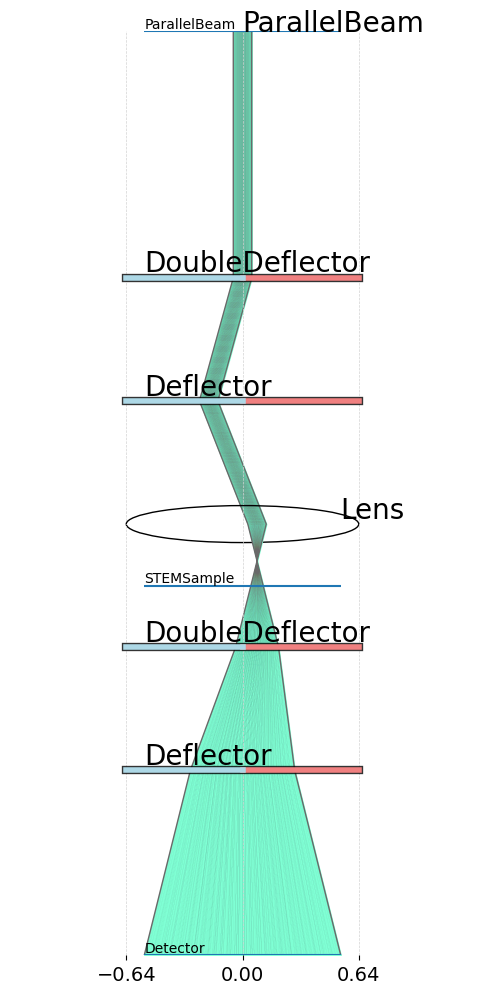

In [66]:
class OverfocusParams(TypedDict):
    overfocus: float  # m
    scan_pixel_size: float  # m
    camera_length: float  # m
    detector_pixel_size: float  # m
    semiconv: float  # rad
    cy: float
    cx: float
    scan_rotation: float
    scan_shape: Tuple[int, int]
    flip_y: bool


def make_model_proto(params: OverfocusParams):
    model = STEMModel()
    model.move_component(model.scan_coils.first, 0.1)
    model.move_component(model.scan_coils.second, 0.15)
    model.move_component(model.objective, 0.2)
    model.move_component(model.sample, 0.225)
    model.move_component(model.descan_coils.first, 0.25)
    model.move_component(model.descan_coils.second, 0.3)
    return model.set_stem_params(
        camera_length=params['camera_length'],
        semiconv_angle=params['semiconv'],
        scan_step_yx=(
            params['scan_pixel_size'],
            params['scan_pixel_size'],
        ),
        scan_shape=params['scan_shape'],
        overfocus=params['overfocus'],
    )


dataset_shape = [128, 128]
overfocus_params = OverfocusParams(
    overfocus=0.01,  # m
    scan_pixel_size=0.01,  # m
    camera_length=0.15,  # m
    detector_pixel_size=0.050,  # m
    semiconv=5,  # rad
    scan_rotation=0,
    flip_y=False,
    scan_shape=tuple(dataset_shape),
    # Offset to avoid subchip gap
    cy=128,
    cx=128,
)

model = make_model_proto(overfocus_params)

# Step the rays through the model to get the ray positions throughout the column
num_rays = 512
yx = (0, 72)
rays = tuple(model.scan_point_iter(num_rays=num_rays, yx=yx))


show_matplotlib(model, rays)


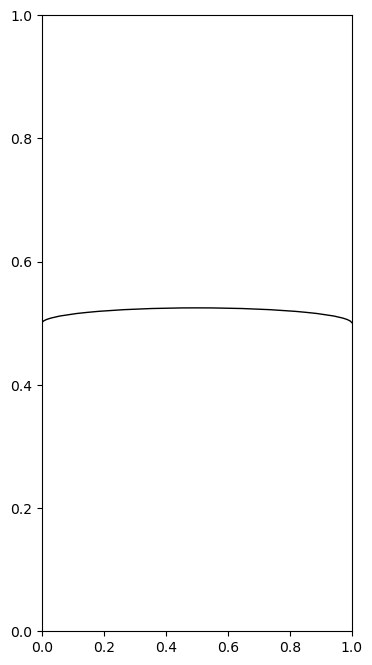

In [67]:
figsize=(4,8)
fig, ax=plt.subplots(figsize = (4, 8))

aspect = figsize[1]/figsize[0]
ax.add_patch(mpl.patches.Arc((0.5, 0.5), 1, height=0.1/aspect,
                            theta1=0, theta2=180, linewidth=1, fill=False, zorder=-1, edgecolor='k'))
